In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


# Predict Future Sales

1. Import Data and Data Preprocessing

2. Exploratory Data Analysis

3. Data Model and Prediction

In [2]:
# Import Sales Train as Main Table
Main_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
Main_df['date'] = pd.to_datetime(Main_df['date'], format = '%d.%m.%Y')

# Create Amount
Main_df['amount'] = Main_df['item_price'] * Main_df['item_cnt_day']
Main_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,amount
0,2013-01-02,0,59,22154,999.00,1.0,999.00
1,2013-01-03,0,25,2552,899.00,1.0,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00


In [3]:
# Data Checking
print('Shape of Sales Data:', Main_df.shape)
print('Missing Entries:',Main_df.isna().sum().sum())
print('Data Type of Sales Data:\n', Main_df.dtypes, '\n')

Shape of Sales Data: (2935849, 7)
Missing Entries: 0
Data Type of Sales Data:
 date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
amount                   float64
dtype: object 



In [4]:
# Import Supplment Information
Shop_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
Shop_df.shape

(60, 2)

In [5]:
Category_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
Category_df.shape

(84, 2)

In [6]:
Item_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
Item_df.shape

(22170, 3)

In [7]:
# Merge the Supplemntory Information into the Main Table
print('Before Merging:', Main_df.shape)
Main_df = pd.merge(Main_df, Shop_df, on = 'shop_id', how = 'left')
Main_df = pd.merge(Main_df, Item_df, on = 'item_id', how = 'left')
Main_df = pd.merge(Main_df, Category_df, on = 'item_category_id', how = 'left')
print('After Merging:', Main_df.shape)

Before Merging: (2935849, 7)
After Merging: (2935849, 11)


In [8]:
# Sum the Negative Count First
Main_df['Year Month'] = Main_df['date'].apply(lambda x:x.strftime('%Y%m'))
Main_df = Main_df.groupby(['Year Month',
                           'shop_id',
                           'item_category_id',
                           'item_id'],as_index = False).agg({'item_cnt_day':'sum',
                                                             'amount':'sum'})

# Exploratory Data Analysis

In [9]:
# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

sns.set_theme()

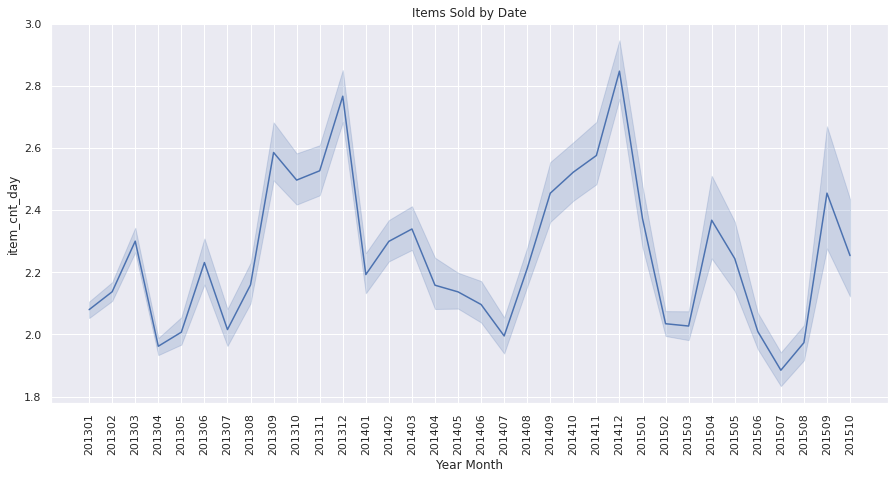

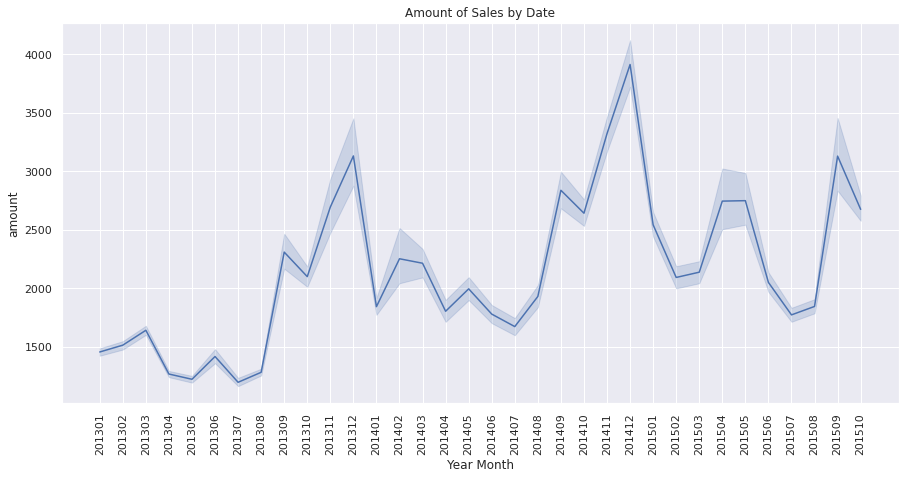

In [10]:
plt.figure(figsize=(15, 7))
sns.lineplot(data = Main_df, x = 'Year Month', y =  'item_cnt_day').set_title('Items Sold by Date')
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize=(15, 7))
sns.lineplot(data = Main_df, x = 'Year Month', y = 'amount').set_title('Amount of Sales by Date')
plt.xticks(rotation = 90)
plt.show()

# Findings:

1. The graph of quantity and amount demonstrated a similar seasonal pattern, where sales are mainly flat across the year, except an peak in December.
2. In general, the quantity sold has demonstrated a minor decrease, especially in 2015. However, the sales amount shows a rise in opposite.
3. In 2015, the quantity seems more volatile comparing to previous 2 years.

# Data Preprocessing

# Dimensonal Reduction

As this dataset is time-series data, the internal sequences and permutations matter. The vector cannot be broken into separate rows like normal regression analysis, where the data will lose its serial feature. Given this circumstance, an autoregression model will suit our purpose well.

However, the prediction requires not only the prediction of item_cnt_date in Nov 2015, but it also considers the differentiation between both shops and products. This requirement greatly increased the dimensionality complexity. Under the massive combinations, we should consider the resource allocation and time complexity beneath.

To accomplish the goal, we will employ a generative model: first conduct a dimensional reduction to differentiate some important clusters, upon which multiple autoregression models will be built for our prediction.

As the prediction interval is by month, we do not have to consider day differentiation. Let us aggregate the data into year month level for our cluster analysis.

In [11]:
# Pivot the Data
Year_Month = Main_df['Year Month'].unique()
Main_df = Main_df.groupby(['Year Month','shop_id','item_category_id','item_id']).agg({'item_cnt_day': 'nunique'}).unstack('Year Month').reset_index()
Main_df.columns = np.concatenate((['shop_id','item_category_id','item_id'],Year_Month.tolist()))
Main_df

,shop_id,item_category_id,item_id,201301,201302,201303,201304,201305,201306,201307,...,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510
0,0,0,16255,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,5740,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,5570,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,5572,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,5573,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,80,9254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
424120,59,83,22087,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
424121,59,83,22088,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
424122,59,83,22091,NaN,NaN,1.0,NaN,1.0,NaN,1.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0


### Missing Data

In [12]:
# How Many Column Missing?
print(Main_df.isna().sum()/ len(Main_df))

shop_id             0.000000
item_category_id    0.000000
item_id             0.000000
201301              0.850930
201302              0.858685
201303              0.849155
201304              0.871174
201305              0.874339
201306              0.867501
201307              0.863165
201308              0.863196
201309              0.878396
201310              0.879540
201311              0.878668
201312              0.843734
201401              0.874282
201402              0.887523
201403              0.883782
201404              0.894512
201405              0.892093
201406              0.890407
201407              0.892116
201408              0.890506
201409              0.904691
201410              0.899569
201411              0.892119
201412              0.860241
201501              0.889714
201502              0.902411
201503              0.904594
201504              0.922487
201505              0.924032
201506              0.924765
201507              0.920950
201508        

Missing values are common in our dataset. To handle the sparse matrix, we must consider our goals and data features. Here are some questions when coming up with a solution.

1. Will the removal of data help, or pose great impacts on our analysis?
2. If we cannot remove the data, what will be the best way of substitution for our data feature?

My thought is the removal of the missing data is not a good choice. We have two ways of removals:

Removing by row or column will either undermine 1) the prediction by shops and products and 2) break the time series dependence.

Then what's next is the substitution. There are three major solutions, replacing them with 0, average, or previous values.

1. replacing the average may not be a good option, as it is referring to the mean of a time series which may undermine the sequential feature.
2. replacing with previous values sounds more rational as it considers the sequential effect, but we are not sure about the daily patterns involved and we may create many additional sales that undermine our model performance.
3. replacing with 0 seems a good choice, as it just keeps the original patterns, and it is common to have no sale on a single day, especially under massive combinations

We admit that there are trade-offs for each method. And we do not have the relevant domain knowledge so we can just do it in a more conservative way here.

In [13]:
# Replace with 0
Main_df = Main_df.replace(np.nan, 0)

Let use an elbow method to evaluate the optimial k cluster for the prediction.

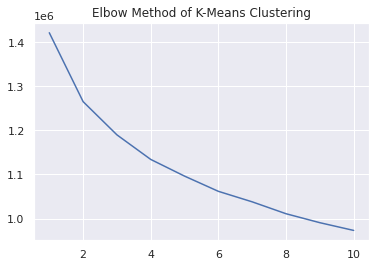

In [14]:
from sklearn.cluster import KMeans

k = [i for i in range(1, 11)]
distance = []

for i in k:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(Main_df.iloc[:,3:])
    distance.append(kmeans.inertia_)
    
plt.title('Elbow Method of K-Means Clustering')
plt.plot(k,
         distance
        )
plt.show()

The elbow method shows that the critical point for optimal k is around 4, where additional clusters do not help to reduce the variances. We will then map the cluster for each combination, and create models upon these 3 clusters generated by the k-mean cluster model.

In [15]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(Main_df.iloc[:,3:])
Main_df['Cluster'] = kmeans.labels_

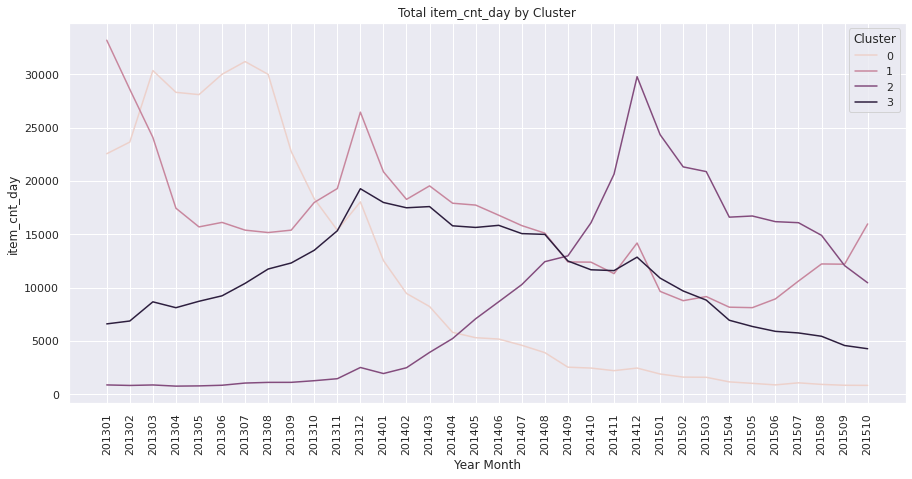

In [16]:
Plot_df = Main_df.iloc[:,3:].groupby('Cluster',as_index = False).sum().melt('Cluster')
Plot_df.columns = ['Cluster','Year Month','item_cnt_day']

plt.figure(figsize=(15, 7))
sns.lineplot(data = Plot_df, x = 'Year Month', y = 'item_cnt_day', hue = 'Cluster').set_title('Total item_cnt_day by Cluster')
plt.xticks(rotation = 90)
plt.show()

In [17]:
# Show Distribution
Main_df['Cluster'].value_counts().sort_index()

0     61880
1    289609
2     48601
3     24034
Name: Cluster, dtype: int64

The cluster plots show some differentiation between clusters:

1. Two clusters share similar patterns where a peak appeared in Dec 2013, while one cluster had a strong re-bounce since June 2015.
2. A cluster shows a gradual downtrend since 2013.
3. A cluster shows a strong surge in 2014.

Then the next step is to build the corresponding model upon the above clusters.
(We did not include specific cluster name and index as it may vary due to random assigning)

# Time Series Model

Let us build forecastting upon the above clustering results!

In [18]:
# Preprocessing 

Model_df = Main_df.iloc[:,3:].melt('Cluster').groupby(['Cluster','variable']).mean().unstack('Cluster').reset_index()
Model_df.columns = ['Year Month','Cluster 0','Cluster 1','Cluster 2','Cluster 3']
Model_df['Year Month'] = pd.date_range('20130101','20151031', freq = 'm')
Model_df = Model_df.set_index('Year Month')

In [19]:
# Plot Summary Graph:

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsap

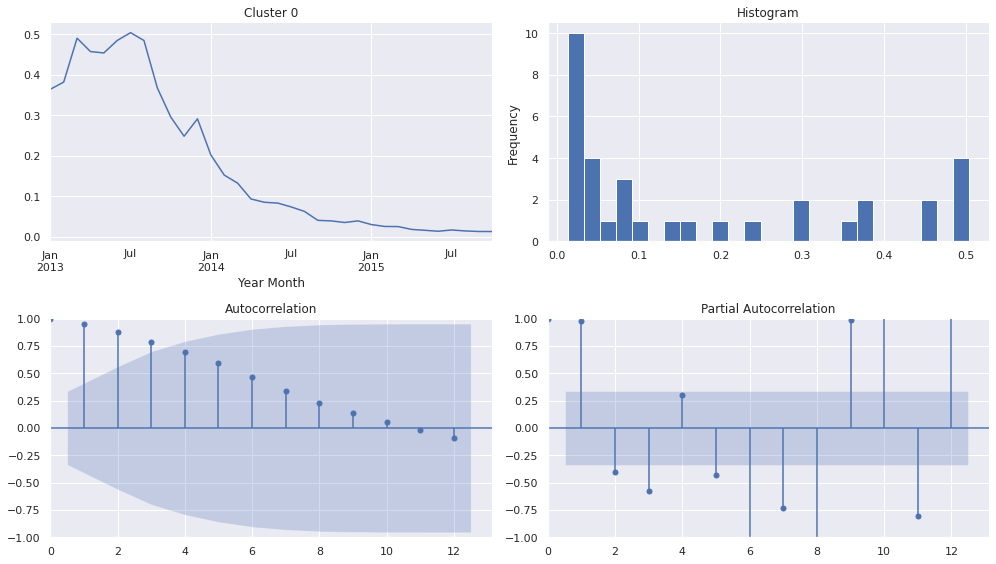

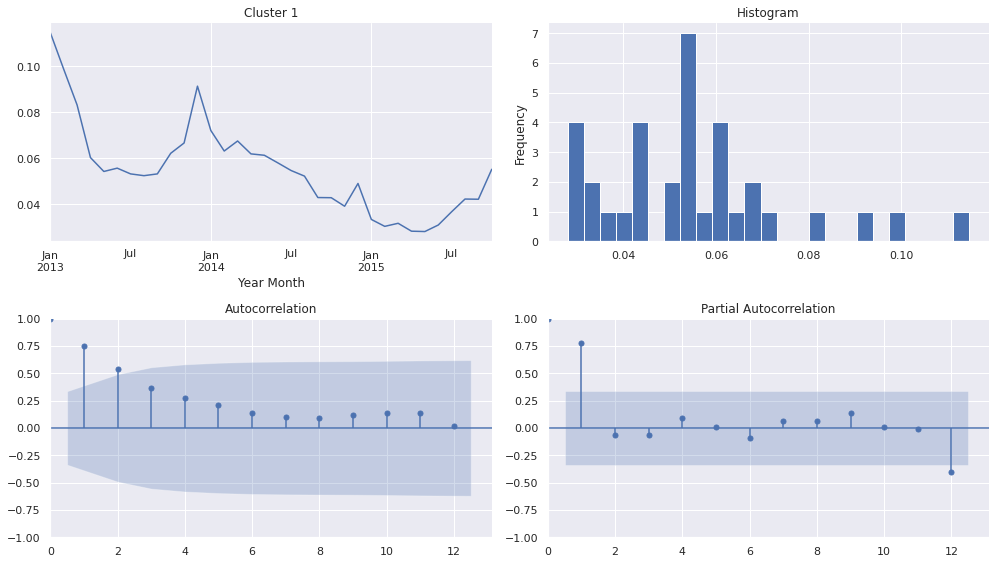

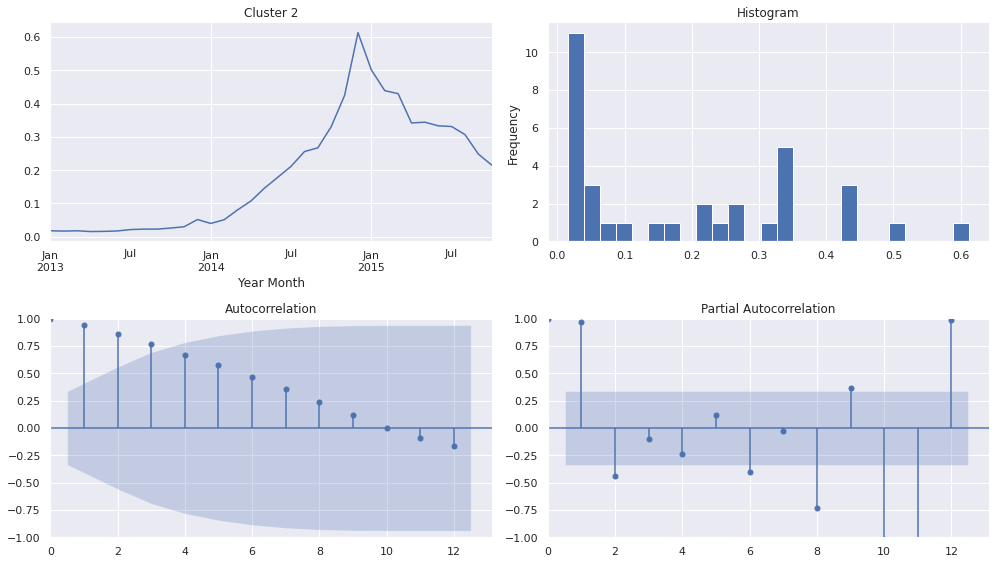

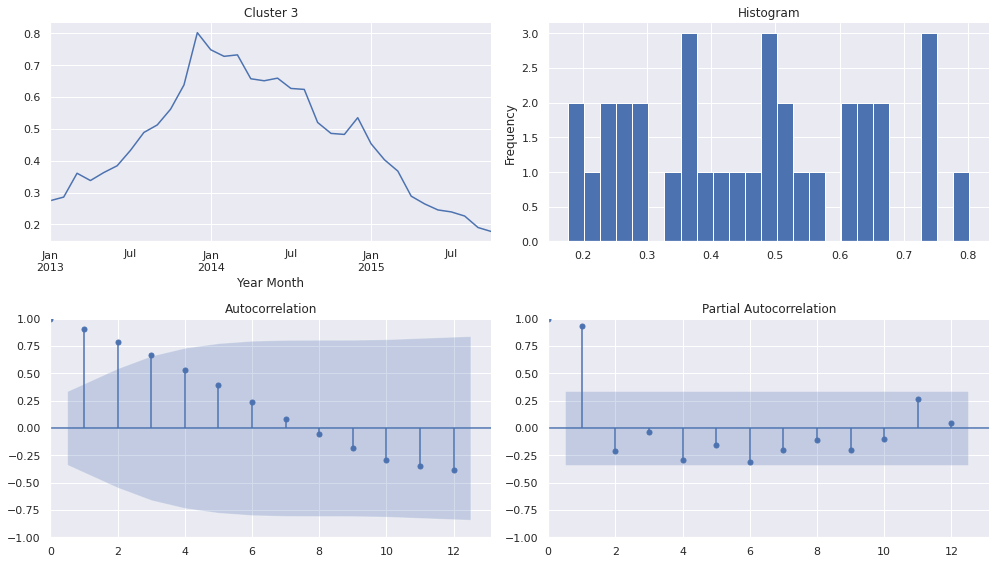

In [20]:
for i in Model_df.columns:
    tsplot(Model_df[i], lags=12, title=i, figsize=(14, 8))

In [21]:
# Train Test Split (9:1)
Train_x = Model_df[:round(len(Model_df)*0.9)]
Test_x = Model_df[round(len(Model_df)*0.1):]

In [22]:
#Model Estimation

# Fit the model
for i in Train_x.columns:
    arima = sm.tsa.arima.ARIMA(Train_x[i], order=(4,0,2),  freq = 'M')
    model_results = arima.fit()
    print(model_results.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequ

                               SARIMAX Results                                
Dep. Variable:              Cluster 0   No. Observations:                   31
Model:                 ARIMA(4, 0, 2)   Log Likelihood                  56.161
Date:                Sat, 23 Jul 2022   AIC                            -96.322
Time:                        09:26:43   BIC                            -84.850
Sample:                    01-31-2013   HQIC                           -92.582
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1926      0.156      1.235      0.217      -0.113       0.498
ar.L1         -0.2867      0.433     -0.662      0.508      -1.135       0.562
ar.L2          0.9577      0.618      1.550      0.1

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              Cluster 1   No. Observations:                   31
Model:                 ARIMA(4, 0, 2)   Log Likelihood                 100.149
Date:                Sat, 23 Jul 2022   AIC                           -184.298
Time:                        09:26:44   BIC                           -172.826
Sample:                    01-31-2013   HQIC                          -180.559
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0654      0.018      3.655      0.000       0.030       0.100
ar.L1          0.8443      4.908      0.172      0.863      -8.776      10.465
ar.L2          0.6053      8.660      0.070      0.9

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              Cluster 2   No. Observations:                   31
Model:                 ARIMA(4, 0, 2)   Log Likelihood                  48.389
Date:                Sat, 23 Jul 2022   AIC                            -80.778
Time:                        09:26:44   BIC                            -69.306
Sample:                    01-31-2013   HQIC                           -77.038
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1808      0.162      1.118      0.264      -0.136       0.498
ar.L1          0.2677      3.945      0.068      0.946      -7.465       8.000
ar.L2          0.7151      2.247      0.318      0.7

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Opps, we observe that most of the default parameters are not working well. Most of the autoregression and moving average do not show a significant p-value (p-value < 0.05). We cannot accept the hypotheses that the autoregression is highly significant to the next-step prediction. Let us try to tune the hyperparameters by AIC and BIC as our evaluation metrics!

In [23]:
# Alternative model selection method, limited to only searching AR and MA parameters

aic_order = []
bic_order = []

for i in Model_df.columns:
    
    train_results = sm.tsa.arma_order_select_ic(Train_x[i], ic=['aic', 'bic'], trend='n', max_ar=5, max_ma=5)
    aic_order.append(train_results.aic_min_order)
    bic_order.append(train_results.bic_min_order)

    print(f'{i} - AIC', train_results.aic_min_order)
    print(f'{i} - BIC', train_results.bic_min_order)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978

Cluster 0 - AIC (1, 5)
Cluster 0 - BIC (1, 0)


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sta

Cluster 1 - AIC (1, 0)
Cluster 1 - BIC (1, 0)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregre

Cluster 2 - AIC (1, 0)
Cluster 2 - BIC (1, 0)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.


Cluster 3 - AIC (2, 1)
Cluster 3 - BIC (1, 0)


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [24]:
# Summarized the AIC Order for Each Model
pd.DataFrame({'Cluster': Model_df.columns,
              'AIC Order': aic_order,
              'BIC Order': bic_order})

,Cluster,AIC Order,BIC Order
0,Cluster 0,"(1, 5)","(1, 0)"
1,Cluster 1,"(1, 0)","(1, 0)"
2,Cluster 2,"(1, 0)","(1, 0)"
3,Cluster 3,"(2, 1)","(1, 0)"


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:              Cluster 0   No. Observations:                   31
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  53.601
Date:                Sat, 23 Jul 2022   AIC                           -101.201
Time:                        09:27:31   BIC                            -96.899
Sample:                    01-31-2013   HQIC                           -99.799
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1942      0.175      1.108      0.268      -0.149       0.538
ar.L1          0.9744      0.042     23.230      0.000       0.892       1.057
sigma2         0.0017      0.000      5.159      0.0

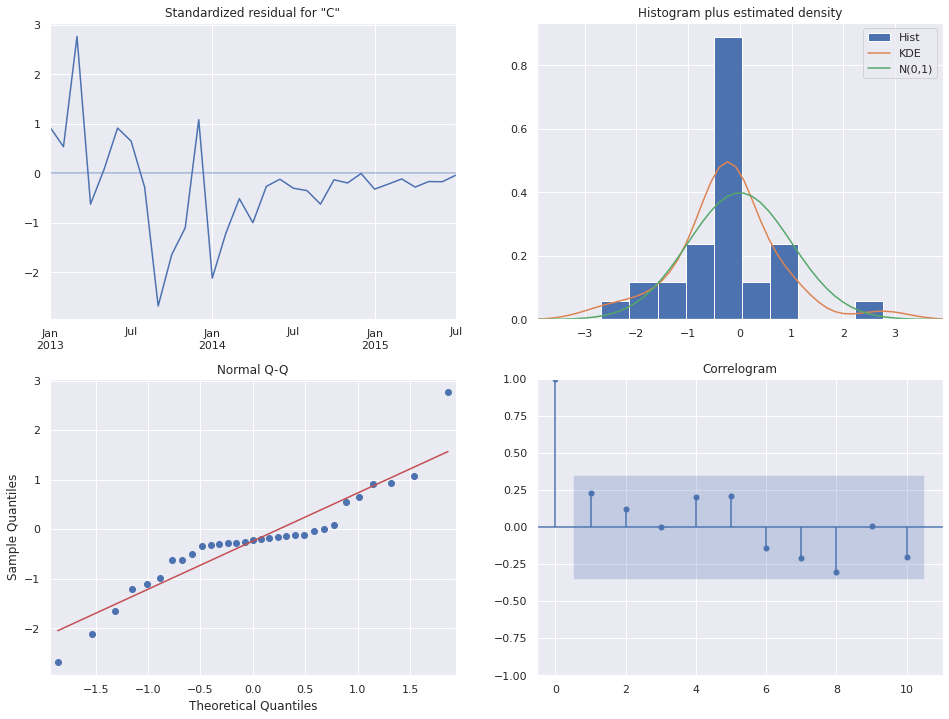

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:              Cluster 1   No. Observations:                   31
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  98.796
Date:                Sat, 23 Jul 2022   AIC                           -191.591
Time:                        09:27:32   BIC                           -187.289
Sample:                    01-31-2013   HQIC                          -190.189
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0666      0.028      2.409      0.016       0.012       0.121
ar.L1          0.9487      0.088     10.776      0.000       0.776       1.121
sigma2      9.261e-05   2.18e-05      4.244      0.0

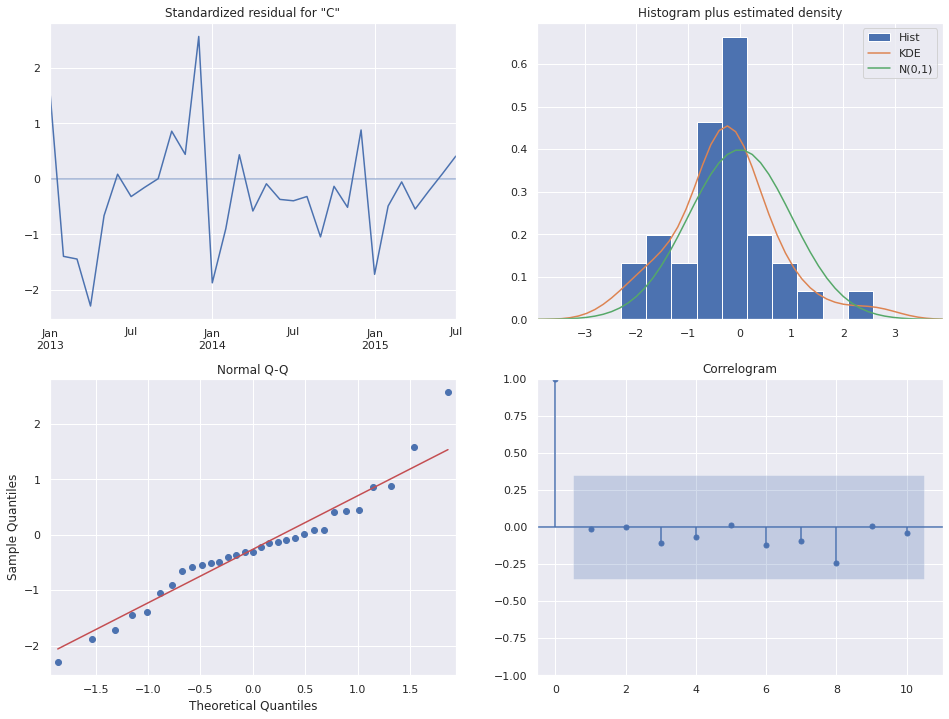

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:              Cluster 2   No. Observations:                   31
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  46.966
Date:                Sat, 23 Jul 2022   AIC                            -87.932
Time:                        09:27:33   BIC                            -83.630
Sample:                    01-31-2013   HQIC                           -86.530
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1785      0.174      1.027      0.304      -0.162       0.519
ar.L1          0.9540      0.053     18.037      0.000       0.850       1.058
sigma2         0.0026      0.000      6.203      0.0

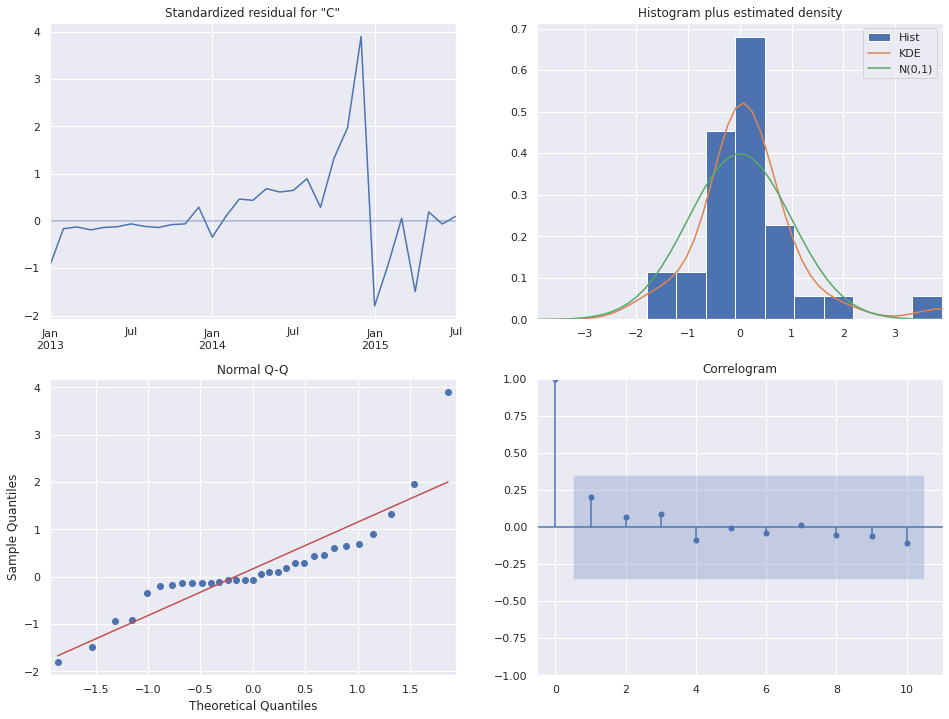

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:              Cluster 3   No. Observations:                   31
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  45.261
Date:                Sat, 23 Jul 2022   AIC                            -84.523
Time:                        09:27:34   BIC                            -80.221
Sample:                    01-31-2013   HQIC                           -83.120
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3596      0.325      1.107      0.268      -0.277       0.996
ar.L1          0.9512      0.084     11.268      0.000       0.786       1.117
sigma2         0.0029      0.001      4.306      0.0

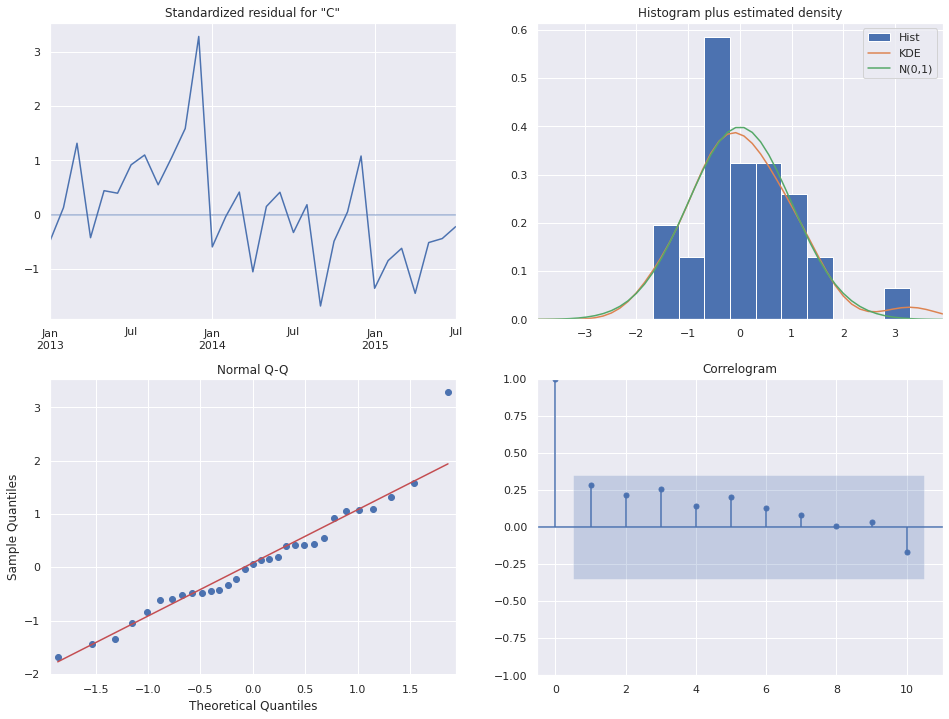

In [25]:
# Model Estimation

# Fit the model
for i in range(4):
    arima = sm.tsa.arima.ARIMA(Train_x.iloc[:, i], order=(bic_order[i][0],
                                                          0,
                                                          bic_order[i][1]),  freq = 'M')
    model_results = arima.fit()
    print(model_results.summary())
    
    # Re-run the above statistical tests, and more. To be used when selecting viable models.

    het_method='breakvar'
    norm_method='jarquebera'
    sercor_method='ljungbox'

    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

    print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
    print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
    print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
    print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
    print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
    print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

    model_results.plot_diagnostics(figsize=(16, 12))
    plt.show()

In [26]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


RMSE: 0.006666926740111071
MAPE: 17.3550621484599
MASE: 0.994982478855642


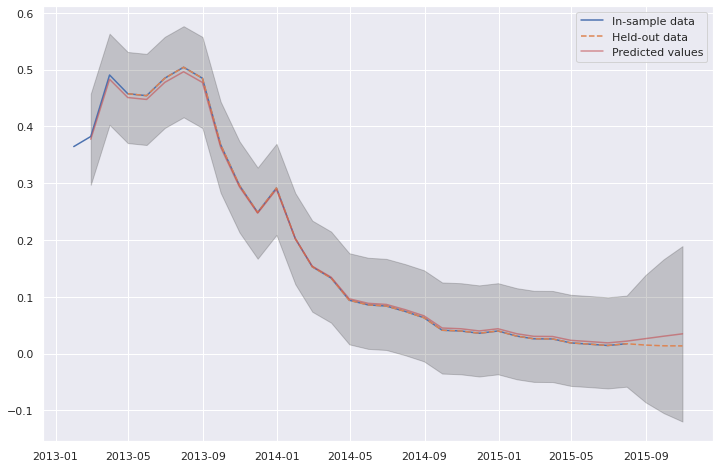

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


RMSE: 0.0025179608839408603
MAPE: 3.006439737513286
MASE: 1.0245657224537854


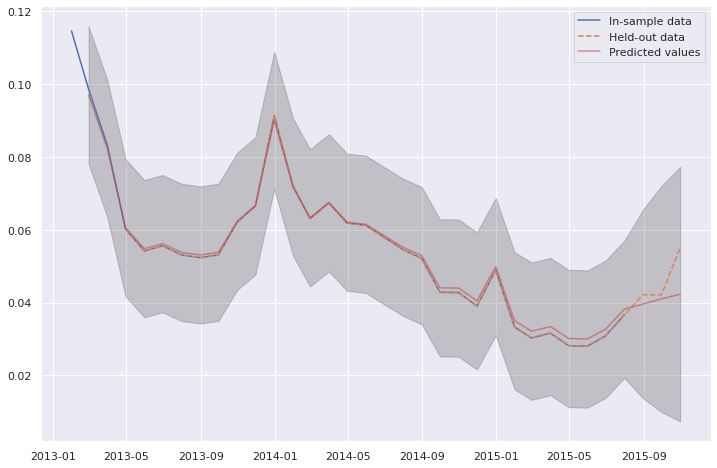

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


RMSE: 0.020397243678104606
MAPE: 16.28127676733055
MASE: 0.9895305639555445


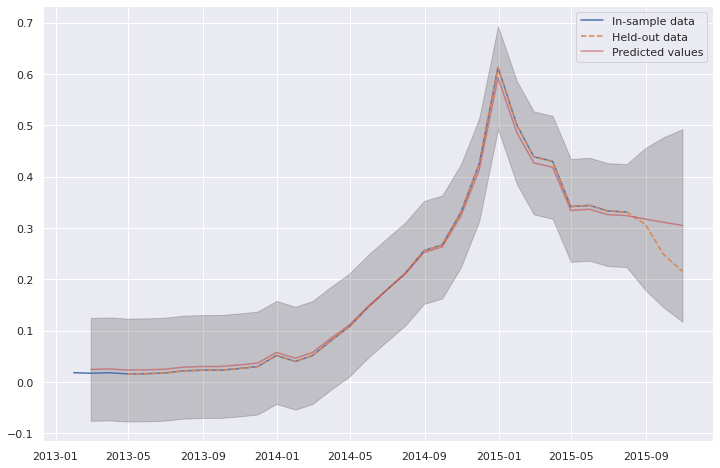

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


RMSE: 0.021057455189654472
MAPE: 4.089894693387831
MASE: 0.9801467172491084


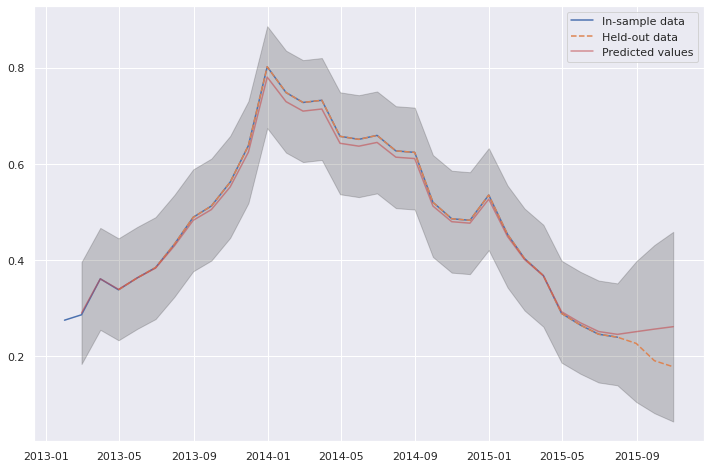

In [27]:
prediction = []

for i in range(4):
    arima = sm.tsa.arima.ARIMA(Train_x.iloc[:, i], order=(bic_order[i][0],
                                                          0,
                                                          bic_order[i][1]),  freq = 'M')
    model_results = arima.fit()
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
    ax1.plot(Train_x.iloc[:, i], label='In-sample data', linestyle='-')
    # subtract 1 only to connect it to previous point in the graph
    ax1.plot(Test_x.iloc[:, i], label='Held-out data', linestyle='--')

    # yes DatetimeIndex
    pred_begin = Train_x.iloc[:, i].index[model_results.loglikelihood_burn]
    pred_end = Test_x.iloc[:, i].index[-1]
    pred = model_results.get_prediction(start = 0, end = len(Model_df))

    pred_mean = pred.predicted_mean[1:]
    pred_mean.index = Model_df.index
    pred_ci = pred.conf_int(alpha=0.05)[1:]
    pred_ci.index = Model_df.index
    
    prediction.append(pred_mean.to_list()[-1])
    
    print('RMSE:', get_rmse(Model_df.iloc[:, i], pred_mean))
    print('MAPE:', get_mape(Model_df.iloc[:, i], pred_mean))
    print('MASE:', get_mase(Model_df.iloc[:, i], pred_mean))
    
    ax1.plot(pred_mean[1:], 'r', alpha=.6, label='Predicted values')
    ax1.fill_between(pred_ci[1:].index,
                     pred_ci.iloc[1:, 0],
                     pred_ci.iloc[1:, 1], color='k', alpha=.2)

    ax1.legend(loc='best');
    plt.show()

After tuning the hyperparameters, the p-value is now significant and the autoregression as 1 is quite relevant to the value in the next time step.


The first two clusters are working quite good on predicting the next time step, but the last 2 are not working fine. It may be caused by the homogeneity problem within the cluster, where the first two are quite homogeneous while the last 2 are quite heterogeneous.

In [28]:
# Predict for Submission
Prediction_by_Cluster = pd.DataFrame({'Cluster': [i for i in range(4)],
                                      'Prediction for Nov 2015':prediction})
Prediction_by_Cluster.head()

,Cluster,Prediction for Nov 2015
0,0,0.034781
1,1,0.042331
2,2,0.304848
3,3,0.261125


As you may be aware, the prediction seems abnormal as they include decimal places. This is a drawback when using a generative model to make an aggregated prediction. It will flatten and reduce all predictions to the same under the same cluster. It may create illogical predictions like here, where product counts should be integers. We also found that the clustering is difficult to tackle cold start problem and sparse matrix. Our approach turns out to seem not very feasible, but it is still a good try to consider dimensionality problems and space-time complexity during time-series modelling!

It is also the reality of retail industry has thousands of products, which makes the prediction and computation difficult. There is some Python package that aims to make the prediction more efficient and scalable, e.g. Prophet. Apart from the package, another issue matters are the use case, whether it is for general business planning or reporting, or it is a real-world inventory management problem. We can scale down like the generative model here, but the latter involves down to product level but not very much about statistical inferences and machine learning explainability, where ML flow and MLops may be helpful to regularize the prediction for the purpose! These are some considerations for our to work on in the future and under a real-world environment!


In [29]:
# Merge 
Submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
Submission = pd.merge(Submission, Main_df[['shop_id','item_id','Cluster']], on = ['shop_id','item_id'], how = 'left')

# Map with Cluster
Submission = pd.merge(Submission, Prediction_by_Cluster, on = 'Cluster', how = 'left')

# If Cold Start, then fill 0
Submission['Prediction for Nov 2015'] = Submission['Prediction for Nov 2015'].fillna(0)
Submission['item_cnt_month'] = Submission['Prediction for Nov 2015']

Submission = Submission[['ID','item_cnt_month']]
Submission

,ID,item_cnt_month
0,0,0.304848
1,1,0.000000
2,2,0.304848
3,3,0.042331
4,4,0.000000
...,...,...
214195,214195,0.304848
214196,214196,0.000000
214197,214197,0.042331
214198,214198,0.000000


In [30]:
Submission.to_csv('submission.csv',index= False)

Reference:

Jeffery Yau at https://www.youtube.com/watch?v=_vQ0W_qXMxk. 